In [ ]:
##Mount Google Drive to Colab VM

from google.colab import drive
drive.mount('/content/drive')

##Navigate to root working folder
%cd /content/drive/My Drive/Springboard/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Springboard


In [474]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import CategoricalNB
from imblearn.over_sampling import SMOTE

In [475]:
sns.set(font_scale = 1.5)

In [476]:
#Quickly redoing Data Wrangling to include more observations and features
X = pd.read_csv('SecondCapstone/data/training_set_features.csv', index_col='respondent_id')  # import training set of data
y = pd.read_csv('SecondCapstone/data/training_set_labels.csv', index_col='respondent_id')  #  import result data
df = X.join(y) #full data set

X.fillna('No Answer', inplace=True) #Since all Data is categorical setting all Null values to their own category
X = X.drop(columns=['employment_occupation', 'employment_industry', 'hhs_geo_region'])# The data in these features are arbitrary values whose corresponding information isn't given so they're basically useless to us
X = pd.get_dummies(X) #One Hot Encoding
X = X.astype('int')  #Assigning all values to Integer datatype for consistency, All ovservations are boolean

#renaming columns to avoid issues with XGBoost later on, XGBoost can't have '<' or ',' in the feature names
X.rename(columns={'education_< 12 Years':'education_less_than_12y','income_poverty_<= $75,000, Above Poverty':'income_poverty_less_than_or_equal_75000_above_poverty','income_poverty_> $75,000':'income_poverty_greater_than_75000' }, inplace=True)

y_h = y.drop(columns='seasonal_vaccine') #Separating Target into h1n1 and seasonal, I'll model each individually
y_s = y.drop(columns='h1n1_vaccine')

X_h = X.join(y_s) #adding target data for other vaccine, adding seasonal as a feature to target h1n1 and vice versa
X_s = X.join(y_h)

In [477]:
#Doing Train Test Split of Data, one for each label

#X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_h, y_h, test_size=0.20) #for testing without using SMOTE

X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_h, y_h, test_size=0.20)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.20)

#using SMOTE to balance the dataset, the Seasonal Label doesn't is already balanced
smote = SMOTE()
X_h1n1, y_h1n1 = smote.fit_resample(X_train_h, y_train_h)

In [497]:
#To resolve array shape warning
y_train_h = np.ravel(y_train_h, order="c")
y_train_s = np.ravel(y_train_s, order="c")

y_test_h = np.ravel(y_test_h, order="c")
y_test_s = np.ravel(y_test_s, order="c")

y_h1n1 = np.ravel(y_h1n1, order="c")

y_s = np.ravel(y_s, order='c')
y_h = np.ravel(y_h, order='c')

In [478]:
# Creating function for confusion matrix as it will be used for every model
# Code taken from https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/

def conf_mat(ytest, ypred):
    pl = metrics.confusion_matrix(ytest,ypred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in pl.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in pl.flatten()/np.sum(pl)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    return sns.heatmap(pl, annot=labels, fmt='', cmap='Blues')

My problem requires a supervised classification model.  I will model and examine the metrics for Ensemble Random Forest, Naive Bayes & XGBoost.

### **Random Forest**

In [ ]:
#Performing Gridsearch for Hyperparameter Tuning
#Grid Search for H1n1 Results

clf_h1n1 = RandomForestClassifier()
clf_seasonal = RandomForestClassifier()

param_grid = {'n_estimators' : np.arange(150, 250, 10)}

In [ ]:
#Grid Search for H1N1 Results

clf_h1n1_cv = GridSearchCV(clf_h1n1, param_grid, cv=3)
clf_h1n1_cv.fit(X_h, y_h)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': array([150, 160, 170, 180, 190, 200, 210, 220, 230, 240])})

In [ ]:
#Grid Search for Seasonal Results

clf_seasonal_cv = GridSearchCV(clf_seasonal, param_grid, cv=3)
clf_seasonal_cv.fit(X_s, y_s)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': array([150, 160, 170, 180, 190, 200, 210, 220, 230, 240])})

In [498]:
#Random Forest Prediction using tuned parameter results

clf_h1n1 = RandomForestClassifier() 
clf_h1n1.set_params(**clf_h1n1_cv.best_params_)

clf_seasonal = RandomForestClassifier()
clf_seasonal.set_params(**clf_seasonal_cv.best_params_)

clf_h1n1.fit(X_h1n1, y_h1n1) #Fitting using dataset with added synthetic observations
clf_seasonal.fit(X_train_s, y_train_s)

y_pred_h1n1 = clf_h1n1.predict(X_test_h)#Testing using Split h1n1 test data
y_pred_seasonal = clf_seasonal.predict(X_test_s)

In [480]:
#Classification Report of model results for Training Data
print('H1N1 Vaccine - Random Forest Classifier')
print(metrics.classification_report(y_test_h, y_pred_h1n1))
print('Seasonal Vaccine - Random Forest Classifier')
print(metrics.classification_report(y_test_s, y_pred_seasonal))

H1N1 Vaccine - Random Forest Classifier
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4204
           1       0.72      0.59      0.65      1138

    accuracy                           0.86      5342
   macro avg       0.80      0.76      0.78      5342
weighted avg       0.86      0.86      0.86      5342

Seasonal Vaccine - Random Forest Classifier
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      2873
           1       0.79      0.77      0.78      2469

    accuracy                           0.80      5342
   macro avg       0.80      0.80      0.80      5342
weighted avg       0.80      0.80      0.80      5342



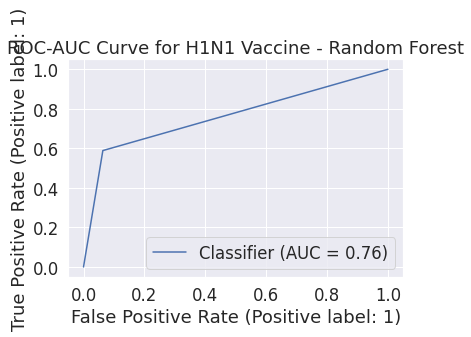

In [481]:
#ROC Curve
metrics.RocCurveDisplay.from_predictions(y_test_h, y_pred_h1n1)
plt.title('ROC-AUC Curve for H1N1 Vaccine - Random Forest')
plt.show()

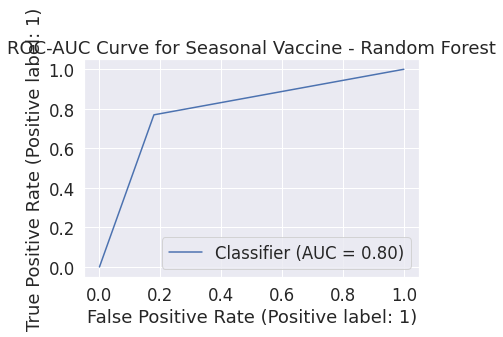

In [482]:
metrics.RocCurveDisplay.from_predictions(y_test_s, y_pred_seasonal)
plt.title('ROC-AUC Curve for Seasonal Vaccine - Random Forest')
plt.show()

In [483]:
#Storing feature scores for each label for further use and graphing
feature_score_h1n1 = pd.Series(clf_h1n1.feature_importances_, index=X_train_h.columns).sort_values(ascending=False)
feature_score_seasonal = pd.Series(clf_seasonal.feature_importances_, index=X_train_s.columns).sort_values(ascending=False)
feature_names = X_train_h.columns

In [473]:
len(clf_h1n1.feature_importances_)

128

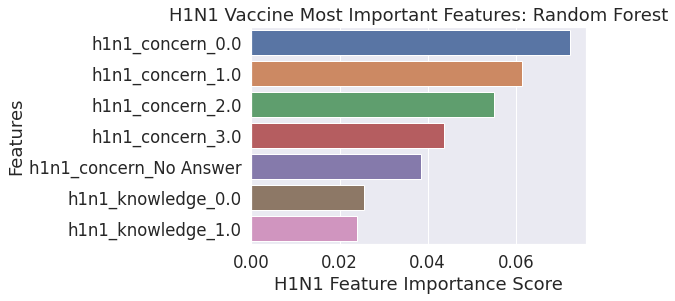

In [484]:
#Barplot of Feature Importance, most important features, H1N1 vaccine
sns.barplot(x=feature_score_h1n1[0:7], y=feature_names[0:7]) #graphing top 7 most important features
plt.title('H1N1 Vaccine Most Important Features: Random Forest')
plt.xlabel('H1N1 Feature Importance Score')
plt.ylabel('Features')
plt.show()

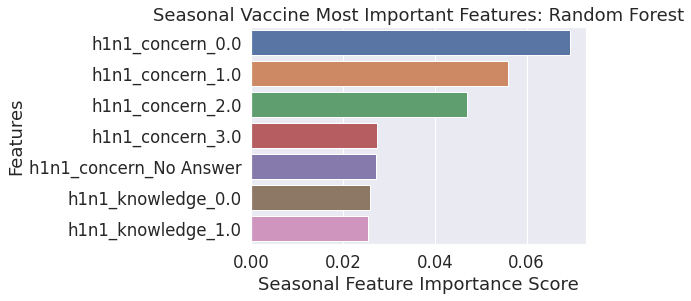

In [485]:
#Barplot of Feature Importance, most important features, seasonal vaccine
sns.barplot(x=feature_score_seasonal[0:7], y=feature_names[0:7]) #graphing top 7 most important features
plt.xlabel('Seasonal Feature Importance Score')
plt.ylabel('Features')
plt.title('Seasonal Vaccine Most Important Features: Random Forest')
plt.show()

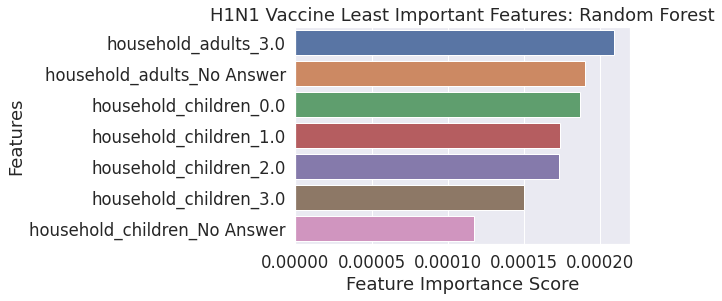

In [486]:
#Barplot of Feature Importance, least important features, H1N1 vaccine
sns.barplot(x=feature_score_h1n1[-8:-1], y=feature_names[-8:-1]) #graphing 7 least important features
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("H1N1 Vaccine Least Important Features: Random Forest")
plt.show()

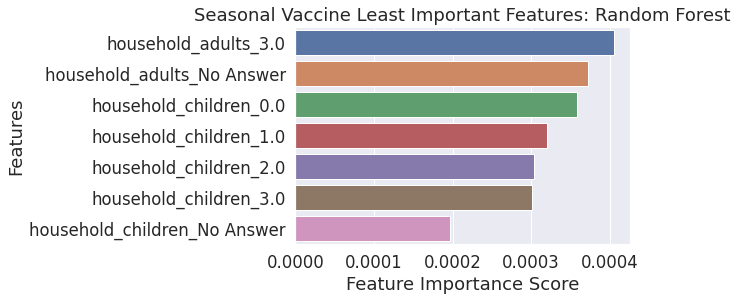

In [487]:
#Barplot of Feature Importance, least important features, seasonal vaccine
sns.barplot(x=feature_score_seasonal[-8:-1], y=feature_names[-8:-1]) #graphing 7 least important features
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Seasonal Vaccine Least Important Features: Random Forest')
plt.show()

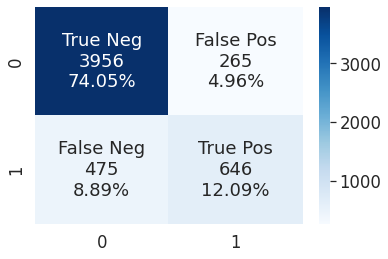

In [ ]:
conf_mat(y_test_h, y_pred_h1n1)  #Confusion Matrix for H1N1 results
plt.show()

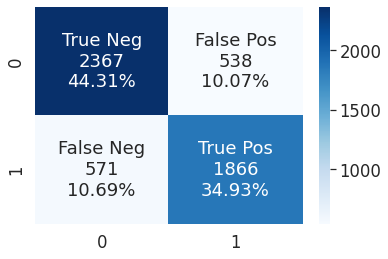

In [ ]:
conf_mat(y_test_s, y_pred_seasonal) #Confusion Matrix for Seasonal results
plt.show()

## **Naive Bayes**

In [ ]:
#Performing Gridsearch for Hyperparameter Tuning - Naive Bayes
#Grid Search for H1n1 Results

cnb_h1n1 = CategoricalNB()
cnb_seasonal = CategoricalNB()

param_grid = {'alpha': np.arange(0.1,1,0.1), 
              'fit_prior': [True, False], 
              'min_categories': np.arange(100,200,10)}

In [ ]:
#Grid Search for H1N1 Results

cnb_h1n1_cv = GridSearchCV(cnb_h1n1, param_grid, cv=3)
cnb_h1n1_cv.fit(X_h, y_h) #gridsearch using original dataset

GridSearchCV(cv=3, estimator=CategoricalNB(),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'fit_prior': [True, False],
                         'min_categories': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190])})

In [ ]:
#Grid Search for Seasonal Results

cnb_seasonal_cv = GridSearchCV(cnb_seasonal, param_grid, cv=3)
cnb_seasonal_cv.fit(X_s, y_s)

GridSearchCV(cv=3, estimator=CategoricalNB(),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'fit_prior': [True, False],
                         'min_categories': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190])})

In [488]:
#Fitting data with best parameters taken from grid search
cnb_h1n1 = CategoricalNB()
cnb_h1n1.set_params(**cnb_cv.best_params_)

cnb_seasonal = CategoricalNB()
cnb_seasonal.set_params(**cnb_seasonal_cv.best_params_)

cnb_h1n1.fit(X_h1n1, y_h1n1)
cnb_seasonal.fit(X_train_s, y_train_s)

y_pred_h1n1 = cnb_h1n1.predict(X_test_h)
y_pred_seasonal = cnb_seasonal.predict(X_test_s)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [489]:
print('H1N1 Vaccine - Naive Bayes Classifier')
print(metrics.classification_report(y_test_h, y_pred_h1n1))
print('Seasonal Vaccine - Naive Bayes Classifier')
print(metrics.classification_report(y_test_s, y_pred_seasonal))

H1N1 Vaccine - Naive Bayes Classifier
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      4204
           1       0.51      0.68      0.58      1138

    accuracy                           0.79      5342
   macro avg       0.71      0.75      0.72      5342
weighted avg       0.82      0.79      0.80      5342

Seasonal Vaccine - Naive Bayes Classifier
              precision    recall  f1-score   support

           0       0.77      0.80      0.78      2873
           1       0.75      0.72      0.74      2469

    accuracy                           0.76      5342
   macro avg       0.76      0.76      0.76      5342
weighted avg       0.76      0.76      0.76      5342



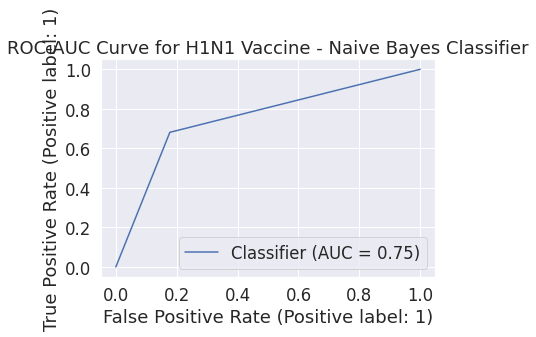

In [490]:
metrics.RocCurveDisplay.from_predictions(y_test_h, y_pred_h1n1)
plt.title('ROC-AUC Curve for H1N1 Vaccine - Naive Bayes Classifier')
plt.show()

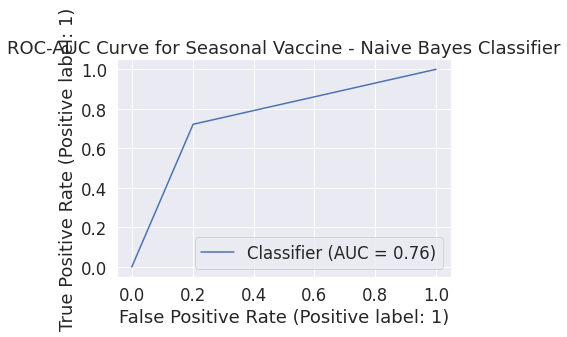

In [491]:
metrics.RocCurveDisplay.from_predictions(y_test_s, y_pred_seasonal)
plt.title('ROC-AUC Curve for Seasonal Vaccine - Naive Bayes Classifier')
plt.show()

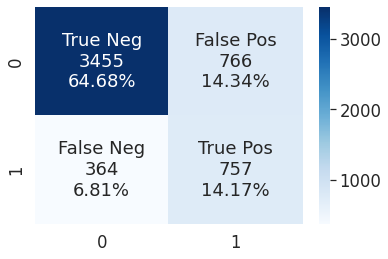

In [ ]:
conf_mat(y_test_h, y_pred_h1n1)  #Confusion Matrix for H1N1 results
plt.show()

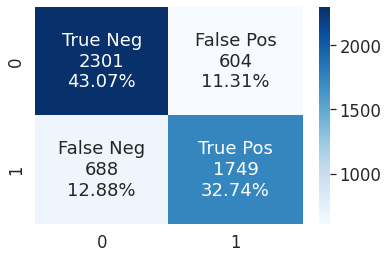

In [ ]:
conf_mat(y_test_s, y_pred_seasonal) #Confusion Matrix for Seasonal results
plt.show()

## **XGBoost**

In [ ]:
#Performing Gridsearch for Hyperparameter Tuning - XGBoost
#Grid Search for H1n1 Results

xgb_h1n1 = xgb.XGBClassifier()
xgb_seasonal = xgb.XGBClassifier()

param_grid = {
 'max_depth': np.arange(3,6,1),
 'min_child_weight': np.arange(1, 3, 1),
 'n_estimators' : np.arange(100, 200, 20),
 'scale_pos_weight': np.arange(1,3,1)}

In [ ]:
#Grid Search for H1N1 Results - XGBoost

xgb_h1n1_cv = GridSearchCV(xgb_h1n1, param_grid, cv=3)
xgb_h1n1_cv.fit(X_h, y_h)

GridSearchCV(cv=3, estimator=XGBClassifier(),
             param_grid={'max_depth': array([3, 4, 5]),
                         'min_child_weight': array([1, 2]),
                         'n_estimators': array([100, 120, 140, 160, 180]),
                         'scale_pos_weight': array([1, 2])})

In [470]:
#Grid Search for Seasonal Results - XGBoost

xgb_seasonal_cv = GridSearchCV(xgb_seasonal, param_grid, cv=3)
xgb_seasonal_cv.fit(X_s, y_s)

KeyboardInterrupt: ignored

In [493]:
xgb_h1n1 = xgb.XGBClassifier()
#xgb_h1n1.set_params(**xgb_h1n1_cv.best_params_)

xgb_seasonal = xgb.XGBClassifier()
#xgb_seasonal.set_params(**xgb_seasonal_cv.best_params_)

xgb_h1n1.fit(X_h1n1, y_h1n1)
xgb_seasonal.fit(X_train_s, y_train_s)

y_pred_h1n1 = xgb_h1n1.predict(X_test_h)
y_pred_seasonal = xgb_seasonal.predict(X_test_s)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [494]:
print('H1N1 Vaccine - XGBoost Classifier')
print(metrics.classification_report(y_test_h, y_pred_h1n1))
print('Seasonal Vaccine - XGBoost Classifier')
print(metrics.classification_report(y_test_s, y_pred_seasonal))

H1N1 Vaccine - XGBoost Classifier
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      4204
           1       0.66      0.67      0.66      1138

    accuracy                           0.86      5342
   macro avg       0.79      0.79      0.79      5342
weighted avg       0.86      0.86      0.86      5342

Seasonal Vaccine - XGBoost Classifier
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      2873
           1       0.80      0.77      0.78      2469

    accuracy                           0.80      5342
   macro avg       0.80      0.80      0.80      5342
weighted avg       0.80      0.80      0.80      5342



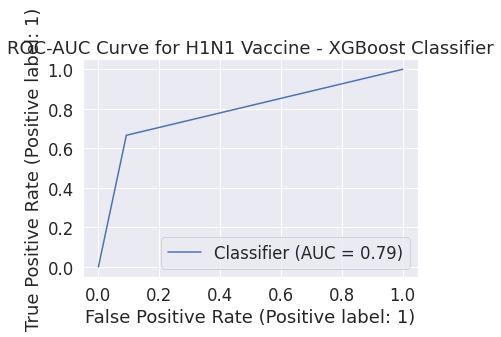

In [495]:
metrics.RocCurveDisplay.from_predictions(y_test_h, y_pred_h1n1)
plt.title('ROC-AUC Curve for H1N1 Vaccine - XGBoost Classifier')
plt.show()

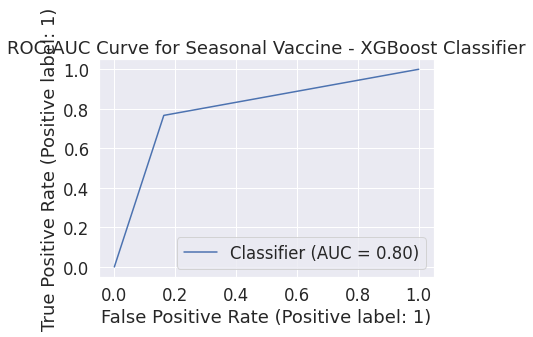

In [496]:
metrics.RocCurveDisplay.from_predictions(y_test_s, y_pred_seasonal)
plt.title('ROC-AUC Curve for Seasonal Vaccine - XGBoost Classifier')
plt.show()

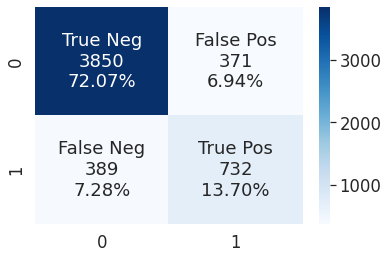

In [ ]:
conf_mat(y_test_h, y_pred_h1n1)  #Confusion Matrix for H1N1 results
plt.show()

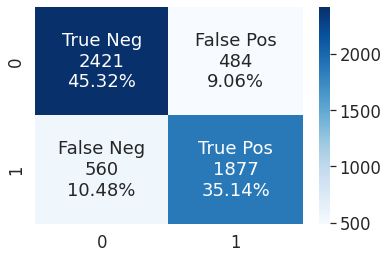

In [ ]:
conf_mat(y_test_s, y_pred_seasonal) #Confusion Matrix for Seasonal results
plt.show()

In [ ]:
#Storing feature scores for each label for further use and graphing
feature_score_h1n1_xgb = pd.Series(xgb_h1n1.feature_importances_, index=X_train_h.columns).sort_values(ascending=False)
feature_score_seasonal_xgb = pd.Series(xgb_seasonal.feature_importances_, index=X_train_s.columns).sort_values(ascending=False)
feature_names_xgb = X_train_h.columns

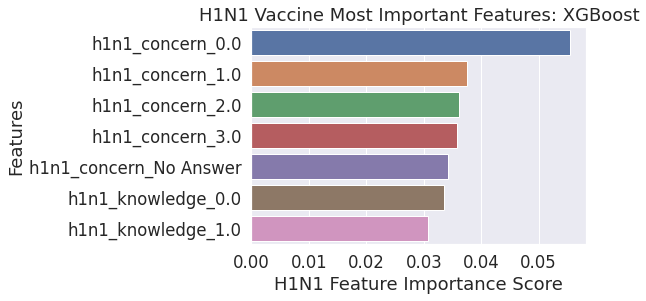

In [ ]:
#Barplot of Feature Importance, most important features, seasonal vaccine
sns.barplot(x=feature_score_h1n1_xgb[0:7], y=feature_names_xgb[0:7]) #graphing top 7 most important features
plt.xlabel('H1N1 Feature Importance Score')
plt.ylabel('Features')
plt.title('H1N1 Vaccine Most Important Features: XGBoost')
plt.show()

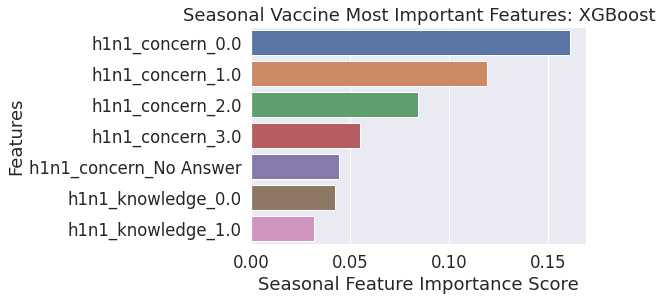

In [ ]:
#Barplot of Feature Importance, most important features, seasonal vaccine
sns.barplot(x=feature_score_seasonal_xgb[0:7], y=feature_names_xgb[0:7]) #graphing top 7 most important features
plt.xlabel('Seasonal Feature Importance Score')
plt.ylabel('Features')
plt.title('Seasonal Vaccine Most Important Features: XGBoost')
plt.show()

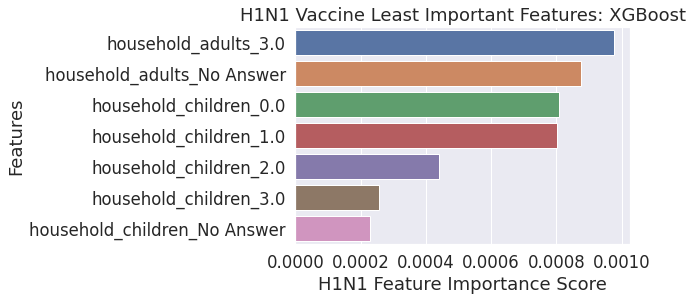

In [ ]:
#Barplot of Feature Importance, most important features, seasonal vaccine
sns.barplot(x=(feature_score_h1n1_xgb[feature_score_h1n1_xgb >0])[-8:-1], y=feature_names_xgb[-8:-1]) #graphing top 7 most important features
plt.xlabel('H1N1 Feature Importance Score')
plt.ylabel('Features')
plt.title('H1N1 Vaccine Least Important Features: XGBoost')
plt.show()

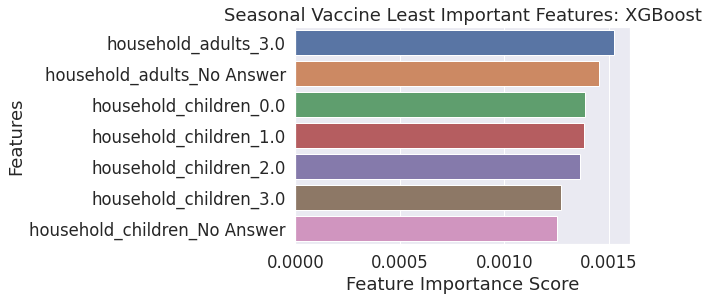

In [ ]:
#Barplot of Feature Importance, least important features, seasonal vaccine
sns.barplot(x=(feature_score_seasonal_xgb[feature_score_seasonal_xgb >0])[-8:-1], y=feature_names[-8:-1]) #graphing 7 least important features
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Seasonal Vaccine Least Important Features: XGBoost')
plt.show()

# **Visualizations for Final Report**

In [ ]:
data_corr=df.corr()

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(data_corr)

In [ ]:
#Correlations before Dummy encoding
#Storing only correlations greater than 20%  or less than -20% to graph
h1n1_corr = data_corr[['h1n1_vaccine']][(data_corr['h1n1_vaccine'] > 0.2) | (data_corr['h1n1_vaccine'] < -0.2)].sort_values(['h1n1_vaccine'], ascending=False)
h1n1_corr.drop('h1n1_vaccine', inplace=True)
h1n1_corr_features = h1n1_corr.index
print(h1n1_corr)

seasonal_corr = data_corr[['seasonal_vaccine']][(data_corr['seasonal_vaccine'] > 0.2) | (data_corr['seasonal_vaccine'] < -0.2)].sort_values(['seasonal_vaccine'], ascending=False)
seasonal_corr.drop('seasonal_vaccine', inplace=True)
print(seasonal_corr)

In [ ]:

sns.catplot(x='index', y='h1n1_vaccine', kind='bar', height=5, aspect=2.5, data=h1n1_corr.reset_index()).set_xticklabels(rotation=-50)
plt.title("Feature Correlation to Taking H1N1 Vaccine")
plt.ylabel('Correlation')
plt.xlabel('Data Feature')
plt.show()

In [ ]:

sns.catplot(x='index', y='seasonal_vaccine', kind='bar', height=5, aspect=2.5, data=seasonal_corr.reset_index()).set_xticklabels(rotation=-50)
plt.title("Feature Correlation to Taking Seasonal Vaccine")
plt.ylabel('Correlation')
plt.xlabel('Data Feature')
plt.show()

In [ ]:
#Correlations after Dummy encoding
data_corr_d=X_h.join(y_h).corr()

#Storing only correlations greater than 20%  or less than -20% to graph
h1n1_corr_d = data_corr_d[['h1n1_vaccine']][(data_corr_d['h1n1_vaccine'] > 0.2) | (data_corr_d['h1n1_vaccine'] < -0.2)].sort_values(['h1n1_vaccine'], ascending=False)
h1n1_corr_d.drop('h1n1_vaccine', inplace=True)
print(h1n1_corr_d)

seasonal_corr_d = data_corr_d[['seasonal_vaccine']][(data_corr_d['seasonal_vaccine'] > 0.2) | (data_corr_d['seasonal_vaccine'] < -0.2)].sort_values(['seasonal_vaccine'], ascending=False)
seasonal_corr_d.drop('seasonal_vaccine', inplace=True)
print(seasonal_corr_d)

In [ ]:
sns.catplot(x='index', y='h1n1_vaccine', kind='bar', height=5, aspect=2.5, data=h1n1_corr_d.reset_index()).set_xticklabels(rotation=-90)
plt.title("Feature Correlation to Taking H1N1 Vaccine")
plt.ylabel('Correlation')
plt.xlabel('Data Features')
plt.show()

In [ ]:
sns.catplot(x='index', y='seasonal_vaccine', kind='bar', height=5, aspect=2.5, data=seasonal_corr_d.reset_index()).set_xticklabels(rotation=-90)
plt.title("Feature Correlation to Taking Seasonal Vaccine")
plt.ylabel('Correlation')
plt.xlabel('Data Features')
plt.show()

In [ ]:
#Storing feature scores for each label for further use and graphing
feature_score_h1n1 = pd.Series(xgb_h1n1.feature_importances_, index=X_train_h.columns).sort_values(ascending=False)
feature_score_seasonal = pd.Series(xgb_seasonal.feature_importances_, index=X_train_s.columns).sort_values(ascending=False)
feature_names = X_train_h.columns

In [ ]:
#Barplot of Feature Importance, most important features, H1N1 vaccine
sns.barplot(x=feature_score_h1n1[0:7], y=feature_names[0:7]) #graphing top 7 most important features
plt.title('H1N1 Vaccine Most Important Features: Random Forest')
plt.xlabel('H1N1 Feature Importance Score')
plt.ylabel('Features')
plt.show()

In [ ]:
sns.catplot(x='h1n1_vaccine', kind='count', height=5, aspect=1.5, data=df).set_xticklabels(['False', 'True'])
plt.title("H1N1 Vaccine")
plt.ylabel("Number of Observations")
plt.xlabel("Took H1N1 Vaccine")
plt.show()

sns.catplot(x='seasonal_vaccine', kind='count', height=5, aspect=1.5, data=df).set_xticklabels(['False', 'True'])
plt.title("Seasonal Vaccine")
plt.ylabel("Number of Observations")
plt.xlabel("Took Seasonal Vaccine")
plt.show()

Based on the Resulting ROC_AUC Scores XGBoost is the best predictive model